**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. B. Keith Jenkins (jenkins@sipi.usc.edu)

**Notebook**: Written by Prof. Keith Chugg.

# Perceptron Leaning
In this notebook, we will use the gradient decent perceptron learning algorithm to train a linear binary classifier.  

We can initialize it with the nearest means classifier and see if it can learn a decision boundary that will separate the data.

In [133]:
import numpy as np 
import matplotlib.pyplot as plt
from utils.previous_notebooks import generate_colored_nongaussian_data, solve_plot_ls_nm_classifier

From the `least_squares_binary_classifier' notebook, we know that data with directional preference can cause problems for the nearest means classifier.  Let's generate some data that is linearly spearable, but for with the nearest means classifier makes classifiaction errors.  

Note: you may have to generat this data a few times to get linearly separable data.  You may also want to try changing some of the parameters so that the data is not linearly separable to see what happens.

w_nm: [ 3.73988681  8.51500982 -0.94260882]


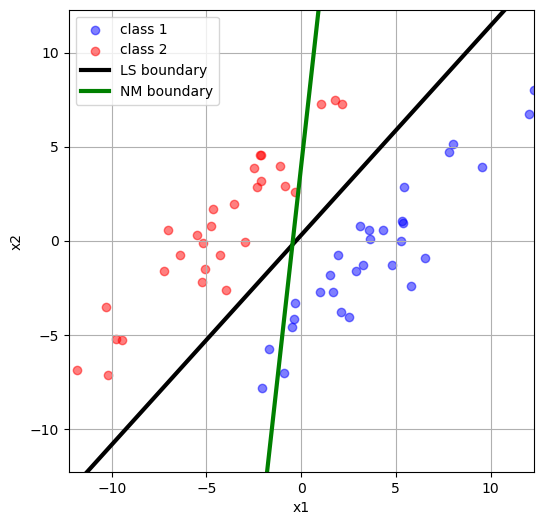

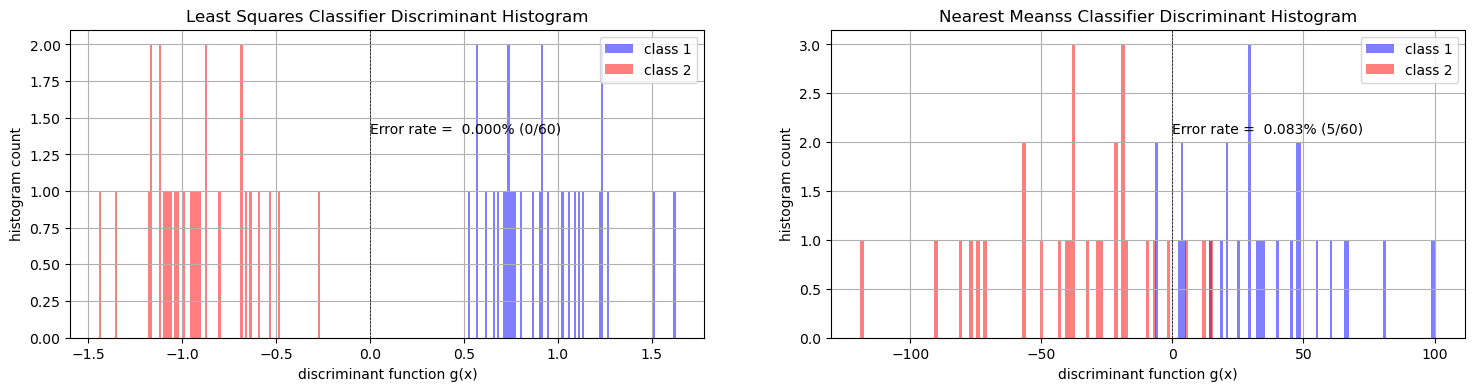

In [136]:
means = np.asarray( [ [5, 0], [-5, 0] ])
lambdas = np.asarray( [ [30, 1], [30, 1] ])  
thetas = np.asarray([ np.pi / 4, np.pi / 4 ])
Ns = np.asarray([30, 30])

x, labels, sample_means = generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='normal')

w_ls, w_nm = solve_plot_ls_nm_classifier(x, labels)

print(f'w_nm: {w_nm}')

Let's implement the perceptron learning algorithm.  Notice that this routine uses gradient descent with the full gradient (not serial or batch-based).  Further, note that it keeps track of the loss, the misclassification rate, and the ${\bf w}$ vector at each epoch so we can plot the learning curves and the evolution of the decision boundary with epochs.

In [183]:
def perceptron_learning(x, labels, w_0, eta=1, max_epochs=40):
    """
    x: (N, D) data array, non-augmented format
    labels:  lengnth array with labels 1, 2
    eta: learning rate (constant)
    max_epochs: max number of passes through the data.  Halts sooner if no classififcation errors
    """
    w_hat = np.copy(w_0)
    z = (-1.0) ** (labels + 1) ## (-1)^(1 + 1) = +1 and (-1)^(2+1) = -1, maps class 1 and class 2 to +1, -1, resp.
    N, D = x.shape
    x_aug = np.ones((N, D + 1))
    x_aug[:, 1:] = x
    zx = (x_aug.T * z).T

    w_hats = np.zeros((max_epochs + 1, D + 1))
    Js = np.zeros(max_epochs + 1)
    error_rates = np.zeros(max_epochs + 1)
    not_done = True
    epoch = 0
    updates_this_epoch = 1
    while not_done:
        reached_max_epochs = epoch == max_epochs
        if not updates_this_epoch or reached_max_epochs:
                not_done = False
        g_zx = zx @ w_hat
        update_indices = g_zx <= 0
        updates_this_epoch = np.sum(update_indices)
        w_hats[epoch] = np.copy(w_hat)
        Js[epoch] = - np.sum(g_zx[update_indices])
        error_rates[epoch] = updates_this_epoch
        print(f'epoch {epoch}\terrors: {updates_this_epoch}\tJ: {Js[epoch]}\tw_hat:{w_hat}')
        w_hat += eta * np.sum(zx[update_indices], axis=0)
        epoch += 1
    error_rates = error_rates / N
    if reached_max_epochs:
        epoch += 1

    return w_hats[:epoch-1], Js[:epoch-1], error_rates[:epoch-1]


Below is a generic routine to plot the evolution of the decision boundaries, the **learning curve** ($J({\bf w})$ vs. epoch), and the watch-metric for the learning curve (error rate).  Note that it is common to track another metric, the error rate in this case, that is not the loss function used for learning.  

In [174]:
def plot_linear_learning(x, labels, w_hats, Js, error_rates):
    """
    x: (N, D) data array, non-augmented format
    labels:  lengnth array with labels 1, 2
    Js: length N_epochs of Loss values (the learning curve)
    error_rates: length N_epochs of misclassification rates as the algorithm learned
    """
    N_epochs = len(Js)
    x_1 = x[labels==1]
    x_2 = x[labels==2]

    fig, ax = plt.subplots(1, 2, sharex=False, figsize=(12, 6))

    ## scatter plot with deciscion boundaries
    LIMIT = np.max(x)
    x_plot = np.arange(-1 * LIMIT, LIMIT, 0.01)
    ax[0].scatter(x_1.T[0], x_1.T[1], fc=(0, 0, 1, 0.5), label='class 1')
    ax[0].scatter(x_2.T[0], x_2.T[1], fc=(1, 0, 0, 0.5), label='class 2')
    for epoch, w_hat in enumerate(w_hats):
        ax[0].plot( x_plot, -1 * ( w_hat[1] *  x_plot  + w_hat[0] ) / w_hat[2], linewidth=2, label=f'epoch {epoch}')
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[0].set_xlim([-LIMIT, LIMIT])
    ax[0].set_ylim([-LIMIT, LIMIT])
    ax[0].legend()
    ax[0].grid(':')

    ## Learning curve
    epochs = np.arange(N_epochs)
    ax[1].plot(epochs, Js, marker='o', color='green', label='J (Loss)')
    # add second y-axis for the metric of error rate: https://pythonguides.com/matplotlib-two-y-axes/
    ax2 = ax[1].twinx() 
    ax2.plot(epochs, error_rates * 100, marker='x', color='purple', label='Error Rate')
    ax[1].set_ylabel('YJ (Loss)', color = 'green') 
    ax[1].tick_params(axis ='y', labelcolor = 'green') 
    ax2.set_ylabel('Yerror rate (%)', color = 'purple') 
    ax2.tick_params(axis ='y', labelcolor = 'purple') 

    # ax[1].set_xlabel('epoch')
    # ax[1].set_ylabel('J (Loss)')
    ax2.set_ylabel('error rate (%)')
    ax[0].legend()
    ax[0].grid(':')


Let's try it with learning rate $\eta =1$:

epoch 0	errors: 5	J: 44.893020757914556	w_hat:[ 3.73988681  8.51500982 -0.94260882]
epoch 1	errors: 26	J: 3112.369099849187	w_hat:[  2.73988681  -0.26039946 -36.55606969]
epoch 2	errors: 10	J: 4673.511144481898	w_hat:[  0.73988681 187.63526313  47.09519324]
epoch 3	errors: 9	J: 1359.901858721561	w_hat:[  2.73988681 177.10387951 -10.2128205 ]
epoch 4	errors: 0	J: -0.0	w_hat:[  5.73988681 166.22496364 -64.90649568]
epoch 5	errors: 0	J: -0.0	w_hat:[  5.73988681 166.22496364 -64.90649568]


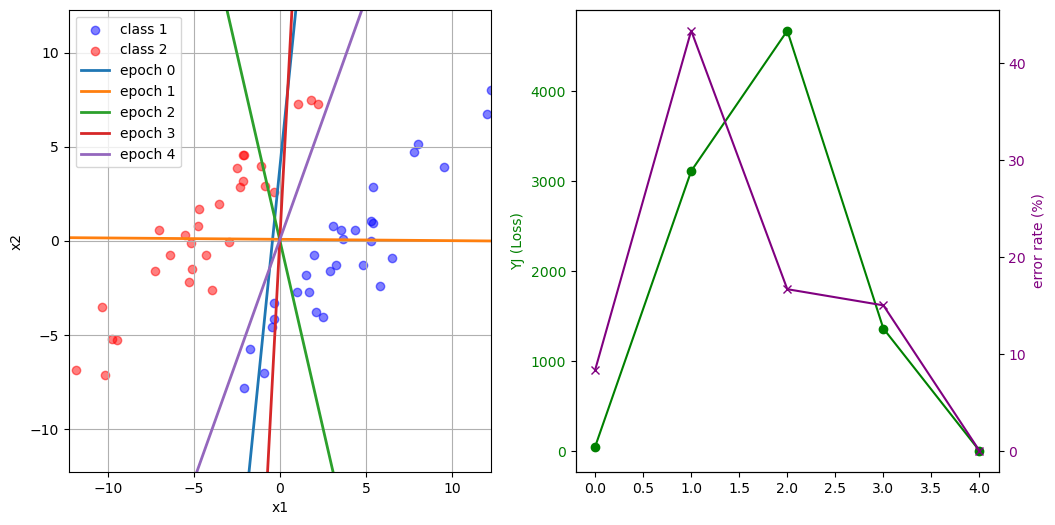

In [186]:
w_hats, Js, error_rates = perceptron_learning(x, labels, w_nm, eta=1, max_epochs=10)
plot_linear_learning(x, labels, w_hats, Js, error_rates)

Notice in the above, the first change in the decision boundary makes the loss larger!  This suggests a smaller learning rate may be better.  

Let's try it with learning rate $\eta = 0.25$:

epoch 0	errors: 5	J: 44.893020757914556	w_hat:[ 3.73988681  8.51500982 -0.94260882]
epoch 1	errors: 3	J: 24.242399222632944	w_hat:[ 3.48988681  6.3211575  -9.84597404]
epoch 2	errors: 0	J: -0.0	w_hat:[ 2.73988681 13.75739682 -4.72217171]
epoch 3	errors: 0	J: -0.0	w_hat:[ 2.73988681 13.75739682 -4.72217171]


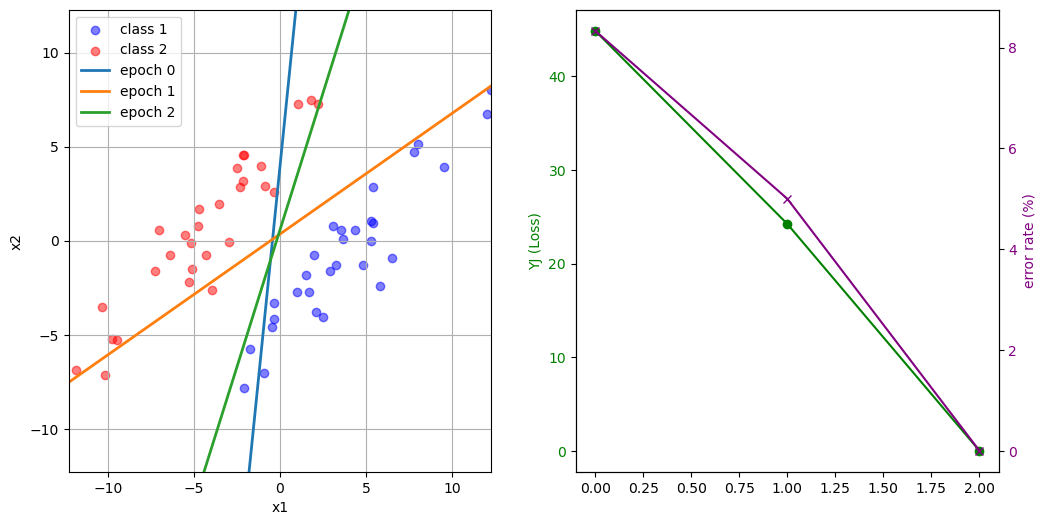

In [181]:
w_hats, Js, error_rates = perceptron_learning(x, labels, w_nm, eta=0.25)
plot_linear_learning(x, labels, w_hats, Js, error_rates)

**Suggestion** Use these routines to generate other data examples and gain intuition.  Here are some questions:
- What happens with the data is not linearly separable?  Is the LS classifier better in this case?  Always?
- Explore how the learning rate affects the convergence of the perceptron learning algorithm.
- What if you genereated another dataset with the same statistics and used this as the test set?  Would you get the same misclassification rate?
- Suppose there are many more points in class 1 than there are in class 2.  Can this impact the decisions for the LS classifier?  How about the perceptron classifier?
- Does the perceptron learning algorithm alsways yield a decision boundary that is maximally distant from the data?  What about the LS classifier?

**Python Tips/Questions (from `perceptron_learning`):**
- Why am I using `np.copy()1 when storing the weights?
- How did I determine decisions -- i.e., how did I compute if there were errors?  
- What does `zx = (x_aug.T * z).T` do?
- 